In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [64]:
import corner
import numpy as np
import matplotlib.pyplot as plt

from emcee.autocorr import integrated_time

In [3]:
import tensorflow as tf

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import helpers
from jokerflow import kepler

In [5]:
session = tf.InteractiveSession()

In [6]:
# These functions are used to transform bounded parameters to parameters to parameters with infinite range
def get_param_for_value(value, min_value, max_value):
    if np.any(value <= min_value) or np.any(value >= max_value):
        raise ValueError("value must be in the range (min_value, max_value)")
    return np.log(value - min_value) - np.log(max_value - value)

def get_value_for_param(param, min_value, max_value):
    return min_value + (max_value - min_value) / (1.0 + np.exp(-param))

def get_bounded_variable(name, value, min_value, max_value, dtype=tf.float64):
    param = tf.Variable(get_param_for_value(value, min_value, max_value), dtype=dtype, name=name + "_param")
    var = min_value + (max_value - min_value) / (1.0 + tf.exp(-param))
    log_jacobian = tf.log(var - min_value) + tf.log(max_value - var) - np.log(max_value - min_value)
    return param, var, tf.reduce_sum(log_jacobian), (min_value, max_value)

# This function constrains a pair of parameters to be a unit vector
def get_unit_vector(name, x_value, y_value, dtype=tf.float64):
    x_param = tf.Variable(x_value, dtype=dtype, name=name + "_x_param")
    y_param = tf.Variable(y_value, dtype=dtype, name=name + "_y_param")
    norm = tf.square(x_param) + tf.square(y_param)
    log_jacobian = -0.5*tf.reduce_sum(norm)
    norm = tf.sqrt(norm)
    x = x_param / norm
    y = y_param / norm
    return x_param, y_param, x, y, log_jacobian

In [19]:
np.random.seed(1234)
T = tf.float64

# Simulate some timestamps
t = np.sort(np.random.uniform(0, 365.0, 25))
t_tensor = tf.placeholder(T, name="t")
feed_dict = {t_tensor: t}

# We will accumulate the log_prior as we go because we'll need to include the
# log Jacobians introduced by the reparameterizations
log_prior = tf.zeros(1, dtype=T)

# The semi-amplitudes and periods
n_planets = 2
log_K = tf.Variable(np.log(np.random.uniform(20, 50, n_planets)), dtype=T)
true_periods = np.random.uniform(4, 25, n_planets)
log_P = tf.Variable(np.log(true_periods), dtype=T)

# Here I'm using a transformation to constrain the omega vector [cos(omega), sin(omega)]
# to be a unit vector. I got this from the Stan manual. We sample in 'w_x' and 'w_y' and
# we will get a uniform distribution over omega.
cw, sw = np.random.randn(2, n_planets)
w_x, w_y, cosw, sinw, log_jac = get_unit_vector("omega", cw, sw, dtype=T)
log_prior += log_jac

# Eccentricity should be constrained to be between 0 and 1.
e_param, e, log_jac, e_range = get_bounded_variable("e", np.random.uniform(0, 0.2, n_planets), 0.0, 1.0, dtype=T)
log_prior += log_jac

# phi is the orbital phase. Like omega above, we'll sample in the unit vector [cos(phi), sin(phi)]
cp, sp = np.random.randn(2, n_planets)
phi_x, phi_y, cosphi, sinphi, log_jac = get_unit_vector("phi", cp, sp, dtype=T)
log_prior += log_jac

# Parameters for the RV zero-point and jitter
rv0 = tf.Variable(0.0, dtype=T)
log_jitter = tf.Variable(np.log(5.0), dtype=T)

# This is the list of parameters that we will fit for
var_list = [log_K, log_P, w_x, w_y, e_param, phi_x, phi_y, rv0, log_jitter]

# Here is an implementation of the RV model
n = 2*np.pi*tf.exp(-log_P)
K = tf.exp(log_K)
w = tf.atan2(sinw, cosw)
phi = tf.atan2(sinphi, cosphi)
jitter2 = tf.exp(2*log_jitter)
t0 = (phi + w) / n

# Solve Kepler's equation and compute the RV signal for each planet
M = n * t_tensor[:, None] - (phi + w)
E = kepler(M, e + tf.zeros_like(M))
f = 2*tf.atan2(tf.sqrt(1+e)*tf.tan(0.5*E), tf.sqrt(1-e)+tf.zeros_like(E))
rv_models = rv0 + K * (cosw*(tf.cos(f)+e) - sinw*tf.sin(f))

# Sum the contributions from each planet
rv_model = tf.reduce_sum(rv_models, axis=1)

# Simulate some fake data from the model
session.run(tf.global_variables_initializer())
y_true = session.run(rv_model, feed_dict=feed_dict)
yerr = np.random.uniform(1.0, 5.0, len(t))
yerr2 = yerr**2
y = y_true + np.sqrt(session.run(jitter2) + yerr2) * np.random.randn(len(t))

# Compute the likelihood
log_like = -0.5 * tf.reduce_sum(
    tf.square(y - rv_model) / (yerr2 + jitter2) + tf.log(yerr2 + jitter2)
)
log_prob = log_prior + log_like

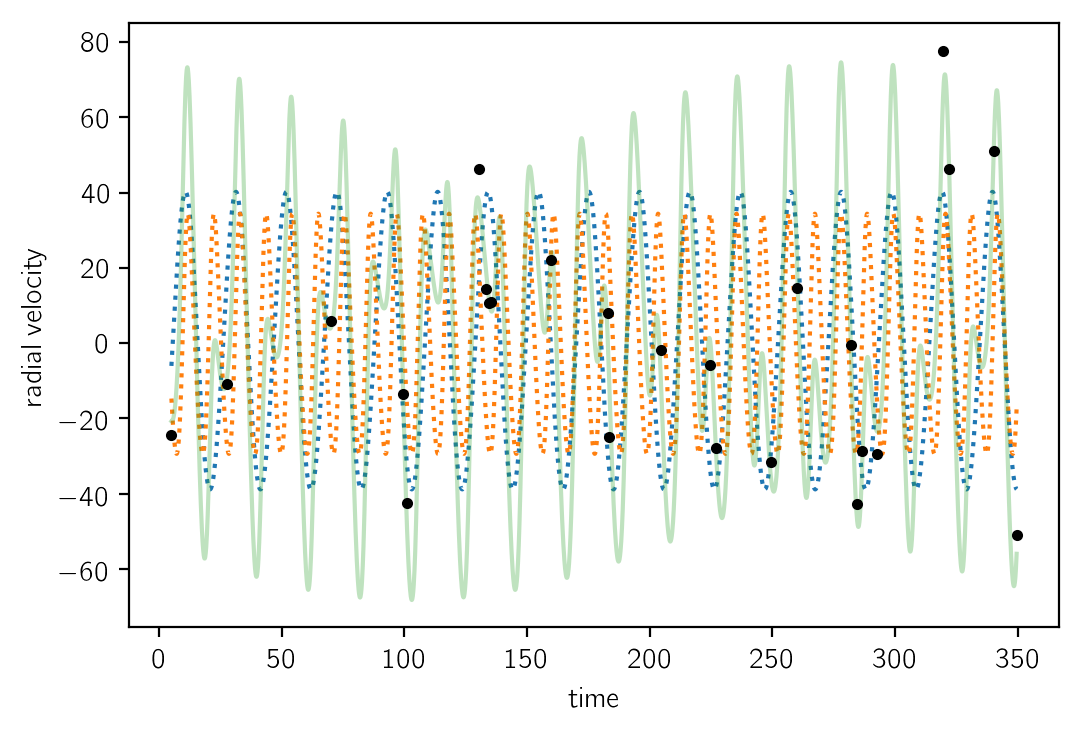

In [20]:
x = np.arange(t.min(), t.max(), 0.1)
fd = {t_tensor: x}
m = session.run(rv_models, feed_dict=fd)
plt.plot(x, m, ":")
plt.plot(x, np.sum(m, axis=1), alpha=0.3)
plt.plot(t, y, ".k")
plt.xlabel("time")
plt.ylabel("radial velocity");

In [21]:
# Initialize by maximizing the log probability
neg_log_prob = -log_prob
opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=var_list)
opt.minimize(session, feed_dict=feed_dict)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 60.646317
  Number of iterations: 910
  Number of functions evaluations: 1100


In [22]:
# We'll use the inverse Hessian to estimate the initial scales of the problem
hess = session.run(tf.hessians(log_prob, var_list), feed_dict=feed_dict)
var = 1.0 / np.abs(np.concatenate([np.diag(np.atleast_2d(h)) for h in hess]))

In [23]:
# Here we run a burn-in where we tune the step size
metric = helpers.DenseMetric(np.diag(var))
nuts = helpers.tf_simple_nuts(
    session,
    log_prob,
    var_list,
    10000,                          # The number of MCMC steps
    helpers.StepSizeEstimator(),       # The integration step size
    metric=metric,                 # The scaling metric computed above
    feed_dict=feed_dict,
    tune=True,
)

1.9e-02, 0.484:   1%|▏         | 131/10000 [00:06<07:13, 22.77it/s]

125 updating metric
1.0 1.0


9.5e-02, 0.483:   2%|▏         | 155/10000 [00:07<06:18, 26.04it/s]

150 updating metric
1.0 1.0


9.2e-02, 0.479:   2%|▏         | 205/10000 [00:09<06:57, 23.48it/s]

200 updating metric
1.0 1.0


9.4e-02, 0.480:   3%|▎         | 305/10000 [00:15<07:18, 22.13it/s]

300 updating metric
1.0 1.0


8.2e-02, 0.483:   5%|▌         | 505/10000 [00:25<07:01, 22.51it/s]

500 updating metric
1.0 1.0


3.0e-02, 0.487:   9%|▉         | 904/10000 [00:48<08:21, 18.14it/s]

900 updating metric
1.0 1.0


9.1e-02, 0.492:  17%|█▋        | 1706/10000 [01:31<06:08, 22.49it/s]

1700 updating metric
1.0 1.0


1.7e-01, 0.496:  49%|████▉     | 4906/10000 [04:07<03:09, 26.87it/s]

4900 updating metric
1.0 1.0


1.3e-01, 0.516: 100%|██████████| 10000/10000 [08:27<00:00, 18.97it/s]


In [ ]:
chain = np.array(nuts[0][5000:])
lp_chain = np.array(nuts[1][5000:])

In [65]:
tau_nuts = integrated_time(chain[:, None, :])
neff_nuts = len(chain) / np.mean(tau_nuts)
tau_nuts, neff_nuts

(array([ 4.31689744,  3.01168705,  4.1204731 ,  6.96259575,  2.87436376,
         4.14084177,  4.5203624 , 10.74048383,  9.32314862,  5.34077982,
         6.96918099,  8.59620935,  4.25158423,  8.35816702,  3.26547665,
         5.285314  ]), 868.8326989694117)

''

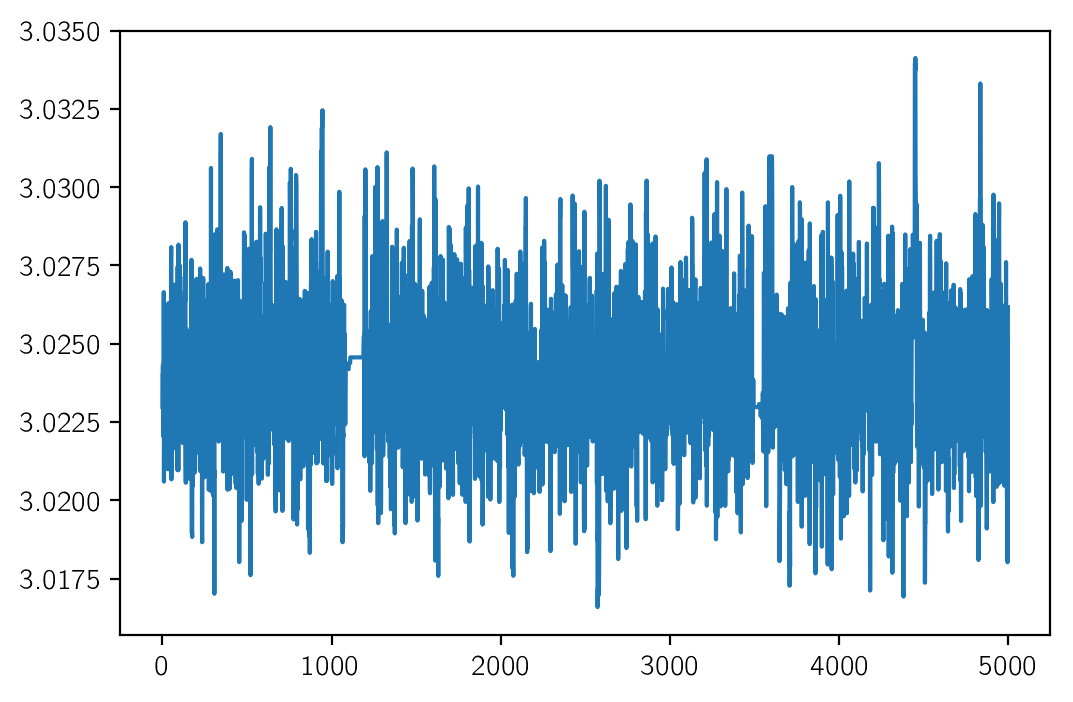

In [67]:
plt.plot(chain[:, 2]);

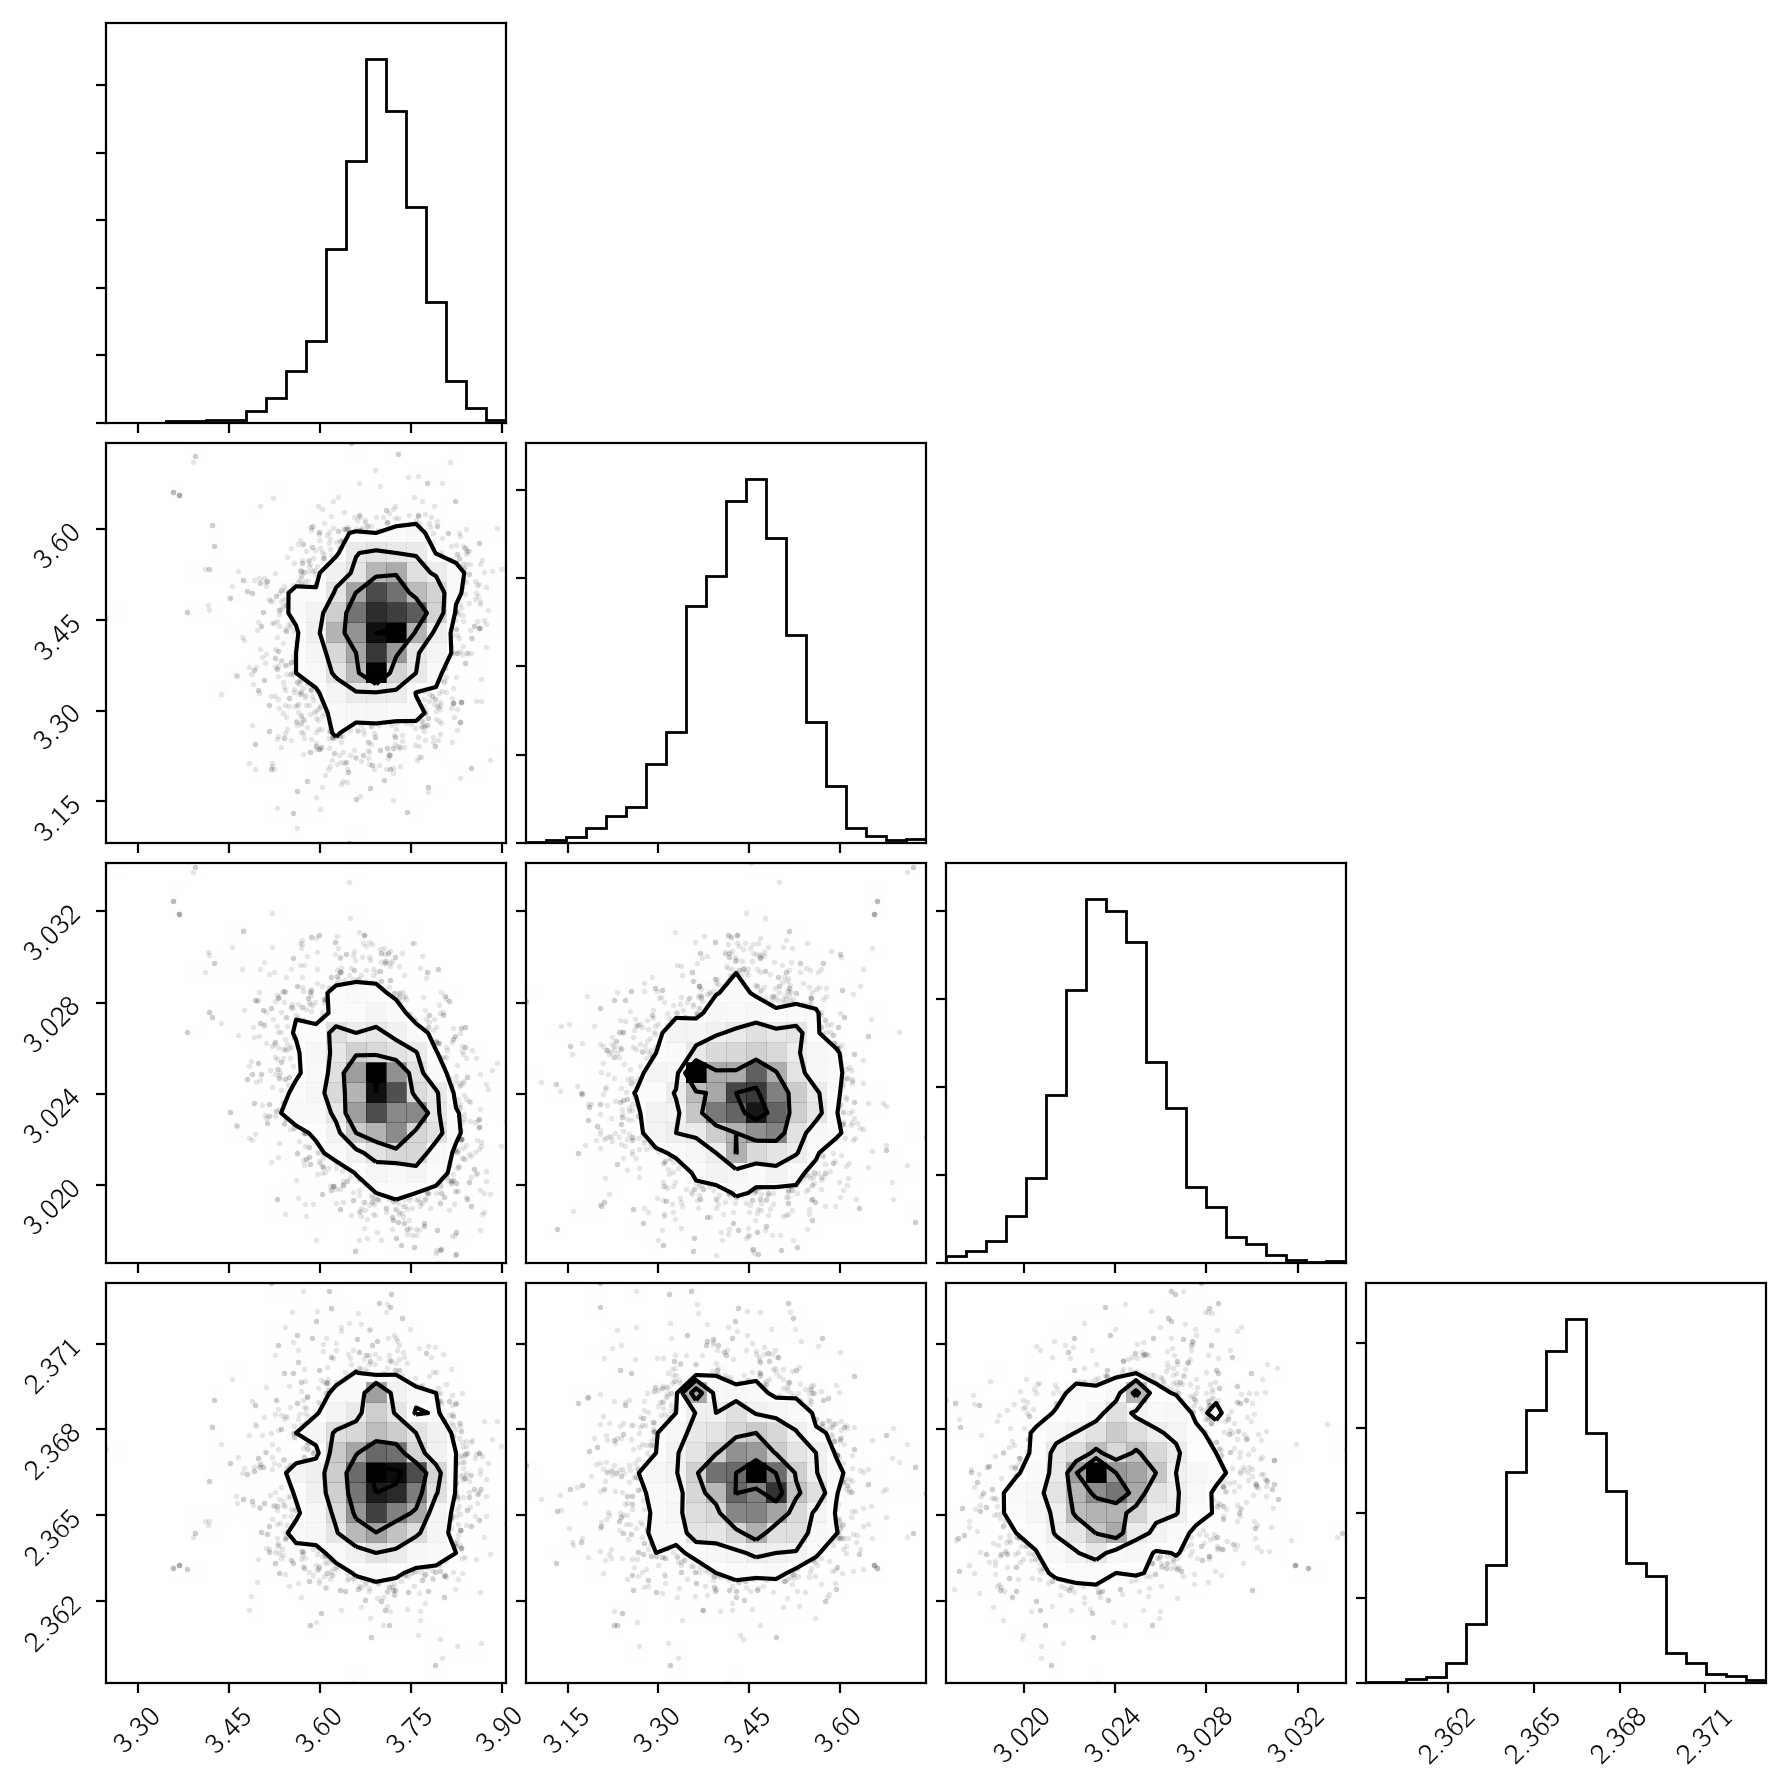

In [44]:
corner.corner(chain[:, :2*n_planets]);

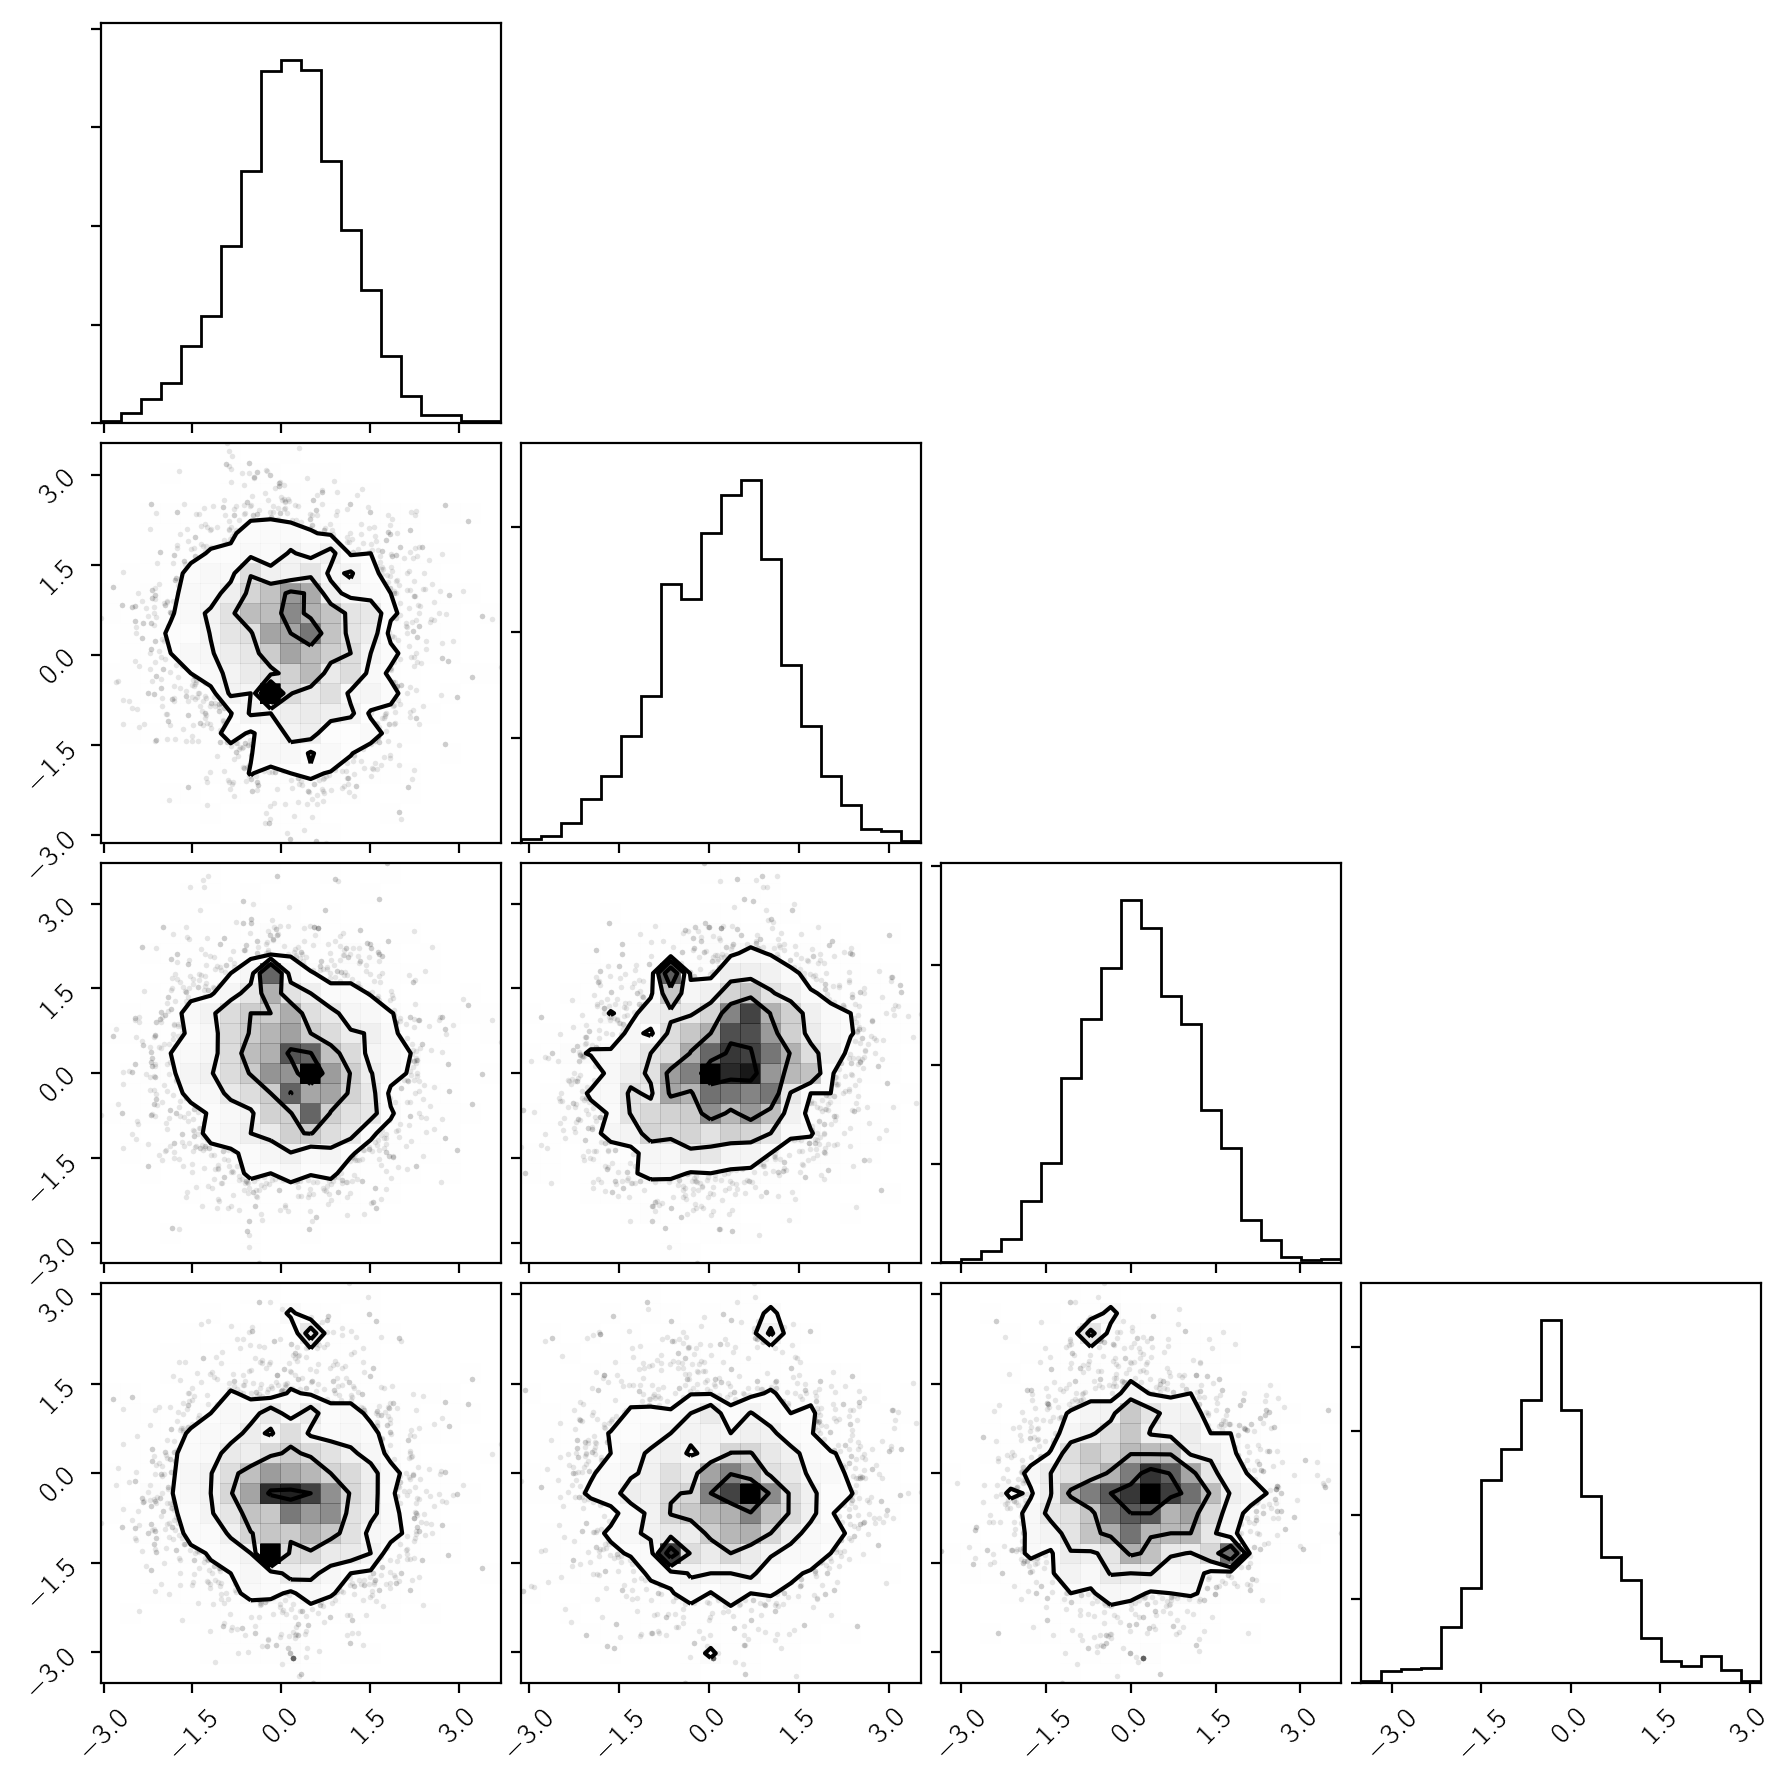

In [45]:
corner.corner(chain[:, 2*n_planets:4*n_planets]);

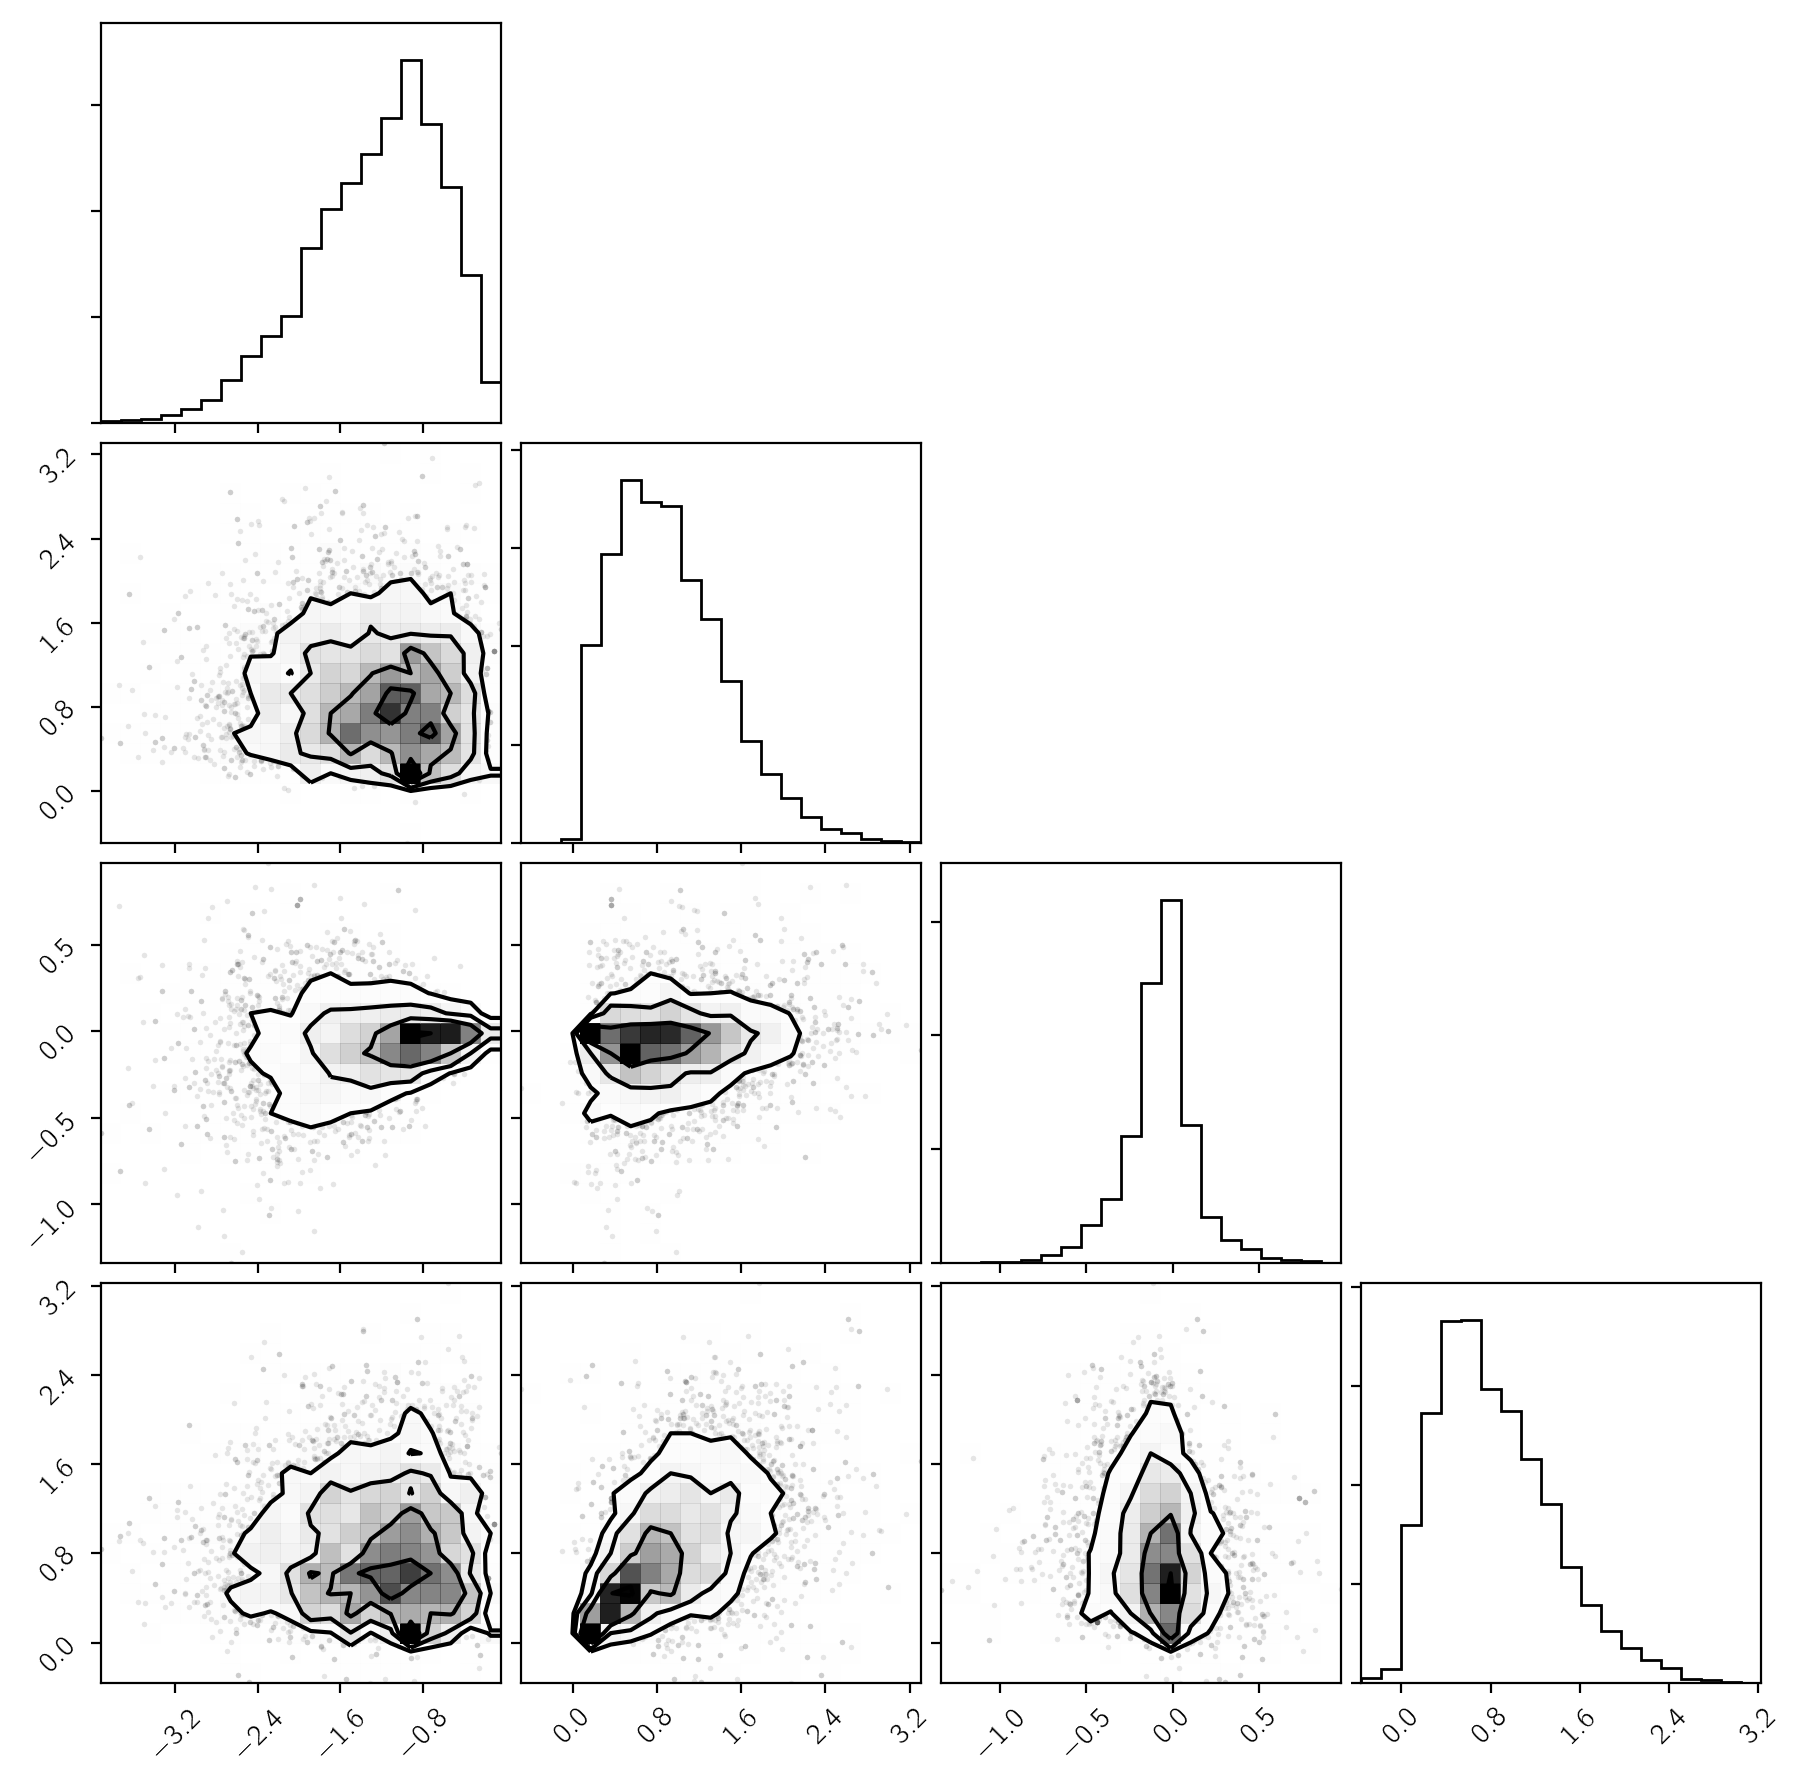

In [46]:
corner.corner(chain[:, 5*n_planets:7*n_planets]);

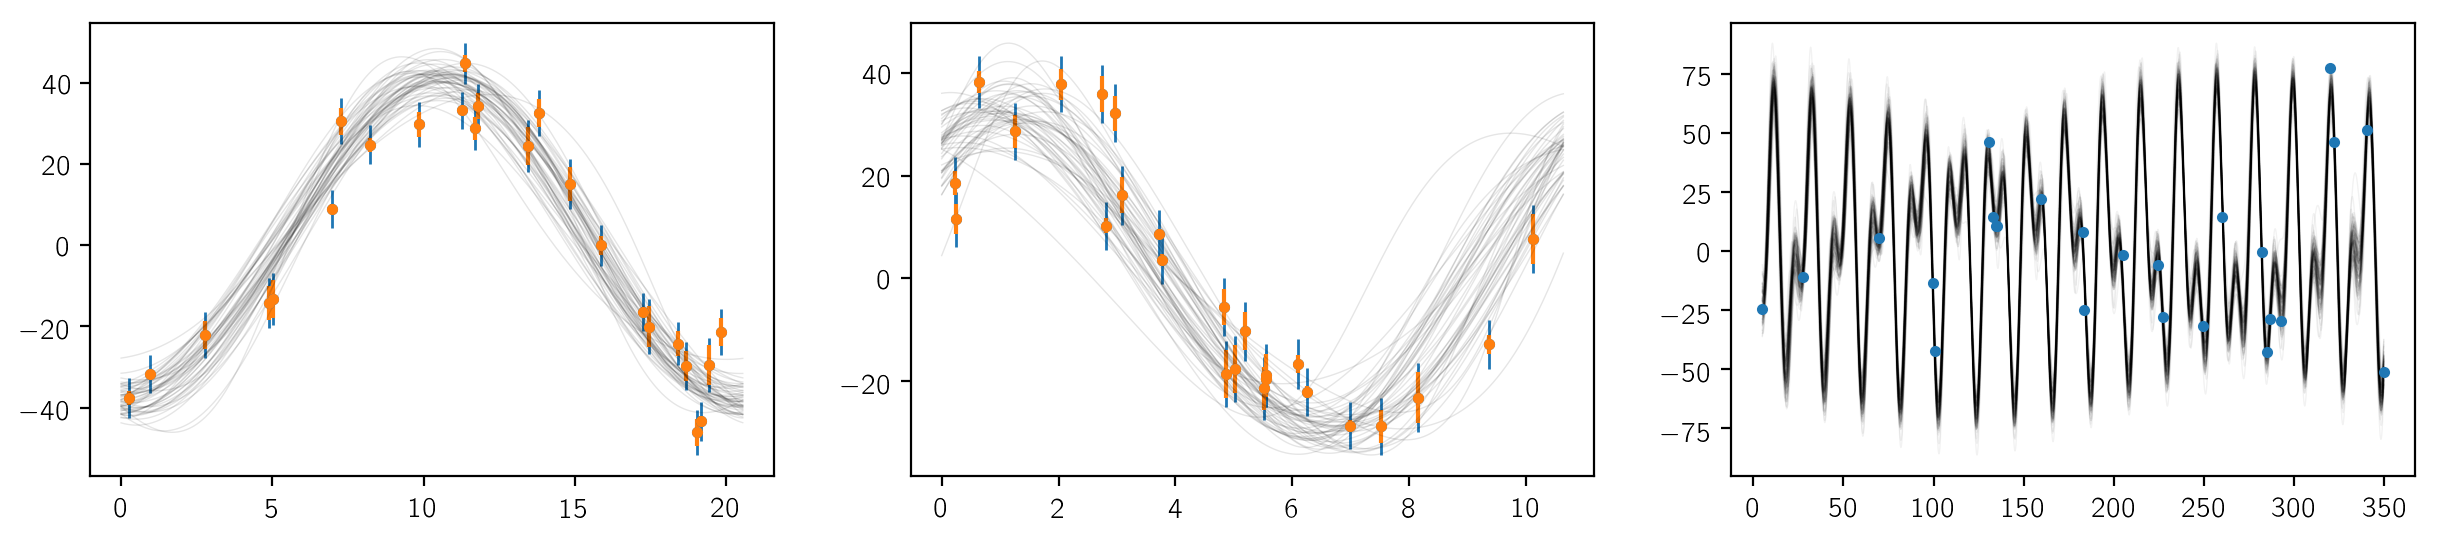

In [71]:
model = helpers.TFModel(log_prob, var_list, feed_dict=feed_dict)
model.setup(session)

best_sample = chain[np.argmax(lp_chain)]
best_feed_dict = model.vector_to_feed_dict(best_sample)

inds = np.random.randint(len(chain), size=100)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

x = np.arange(t.min(), t.max(), 0.1)
for i in inds:
    sample = chain[i]
    fd = model.vector_to_feed_dict(sample)
    
    fd[t_tensor] = x
    m = session.run(rv_model, feed_dict=fd)
    ax3.plot(x, m, "k", alpha=0.05, lw=0.5)

ax3.plot(t, y, ".")

models, periods, err = session.run([rv_models, tf.exp(log_P), tf.sqrt(yerr2+jitter2)], feed_dict=best_feed_dict)

x1 = np.linspace(0, periods[0], 1000)
x2 = np.linspace(0, periods[1], 1000)

for i in np.random.randint(len(nuts[0]), size=50):
    sample = nuts[0][i]
    fd = model.vector_to_feed_dict(sample)
    t0_value = session.run(t0, feed_dict=fd)
#     print(t0_value)
#     assert 0
    
    fd[t_tensor] = x1
    m = session.run(rv_models, feed_dict=fd)
    ax1.plot(x1, m[:, 0], "k", alpha=0.1, lw=0.5)
    
    fd[t_tensor] = x2
    m = session.run(rv_models, feed_dict=fd)
    ax2.plot(x2, m[:, 1], "k", alpha=0.1, lw=0.5)

ax1.errorbar(t%periods[0], y - models[:, 1], fmt=".", yerr=err, lw=1)
ax1.errorbar(t%periods[0], y - models[:, 1], fmt=".", yerr=yerr)
ax2.errorbar(t%periods[1], y - models[:, 0], fmt=".", yerr=err, lw=1)
ax2.errorbar(t%periods[1], y - models[:, 0], fmt=".", yerr=yerr);